In [1]:
##Import the necessary libraries

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
##Let's take a look at our data
##I see this is a dataset containing health information of various patients, "num" is the target

data = pd.concat([X, y], axis=1)

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [4]:
##All numerical, but from domain knowledge I am aware some of these such as sex is supposed to be categorical

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [5]:
##Very few missing data points, dropping them won't cause issues

null = data.isnull().sum()
duplicates = data.duplicated().sum()

print(f'Missing data: {null}')
print(f'Duplicates: {duplicates}')

Missing data: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Duplicates: 0


In [6]:
data = data.dropna()

print(data.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [7]:
##Now let's take a look at the data satistically
##Again, based off research and domain knowledge, I notice a few unusual maxes in "chol" and "trestbps". I also
##see an imbalance within our target variable "num", switching this to binary is likely going to allow for enhanced
##model performance. I also have noticed in a lot of cases that a high standard deviation indicates the presence
##of outliers, so let's visualize to take a better look.


data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


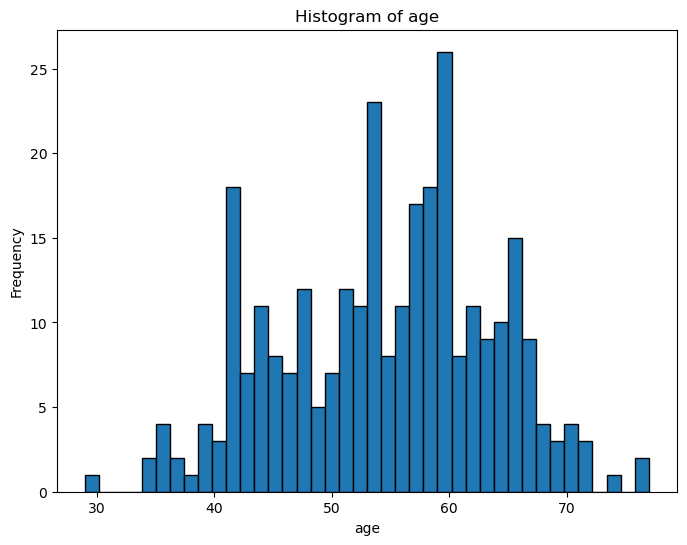

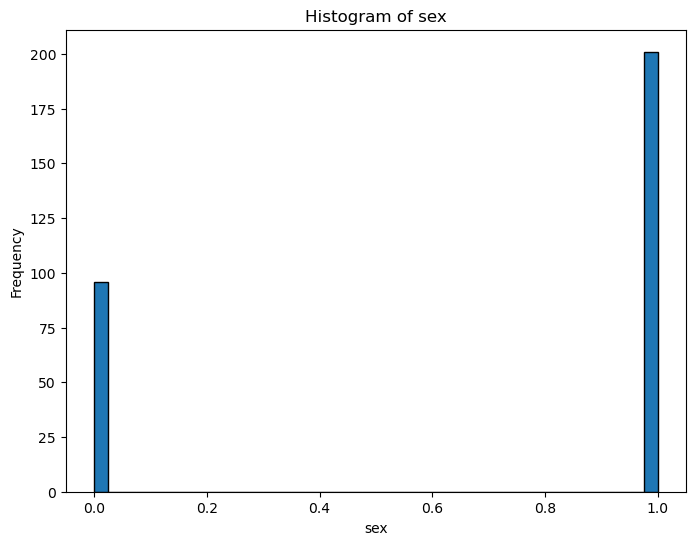

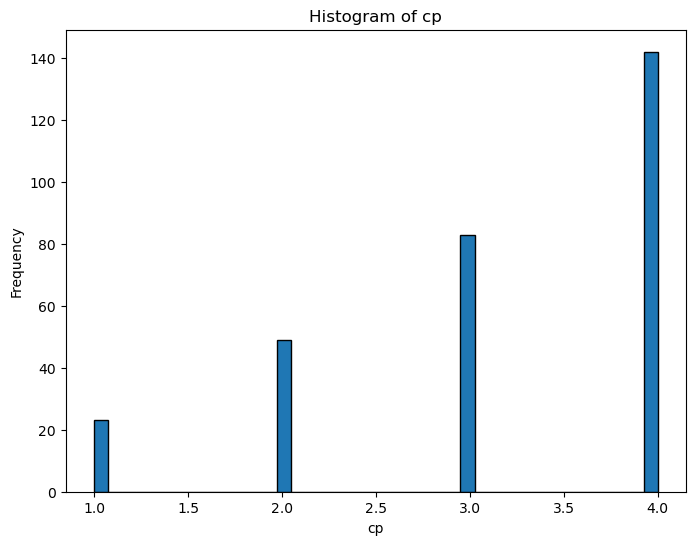

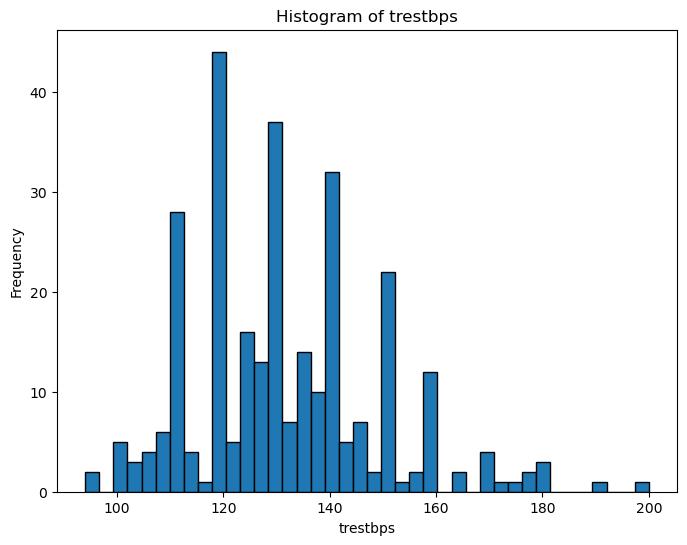

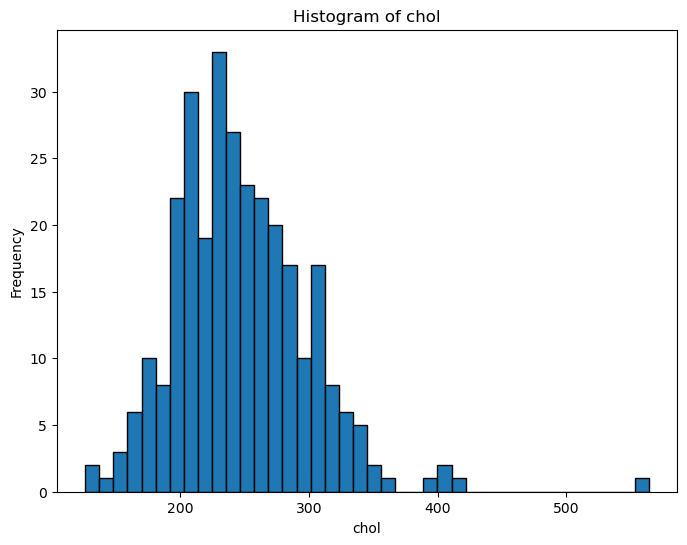

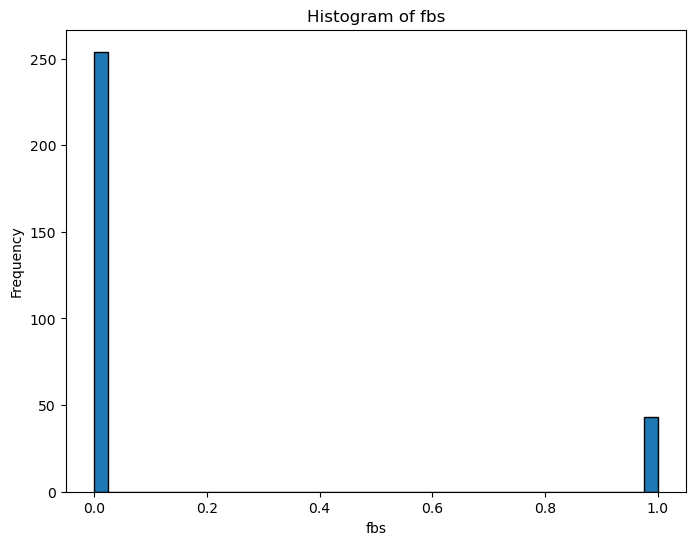

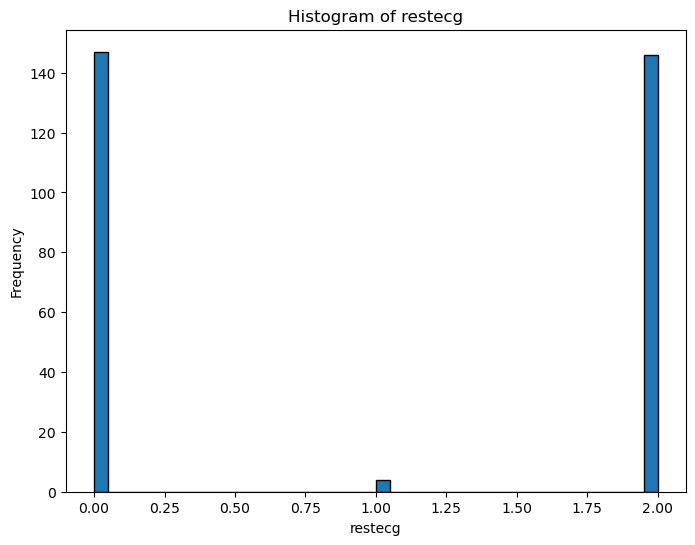

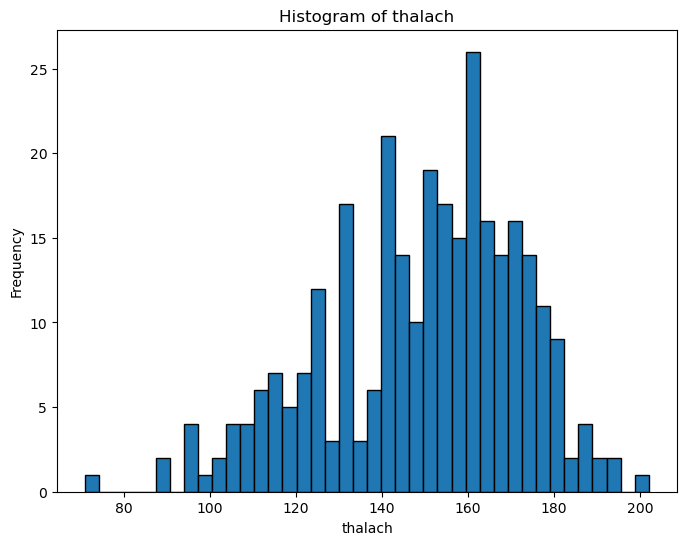

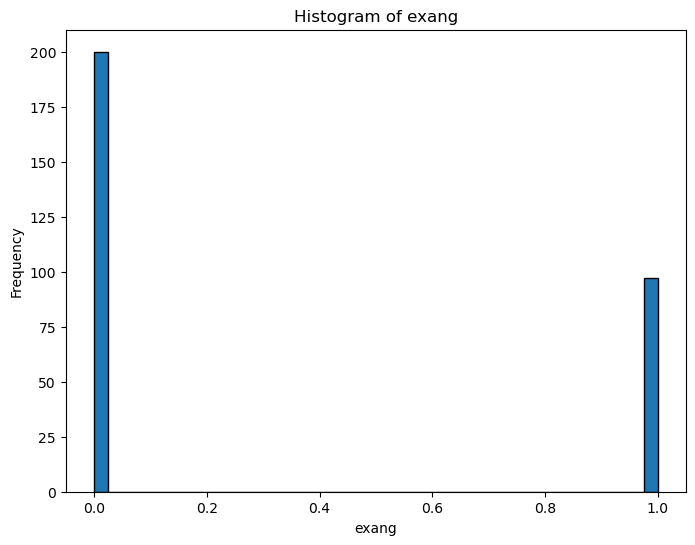

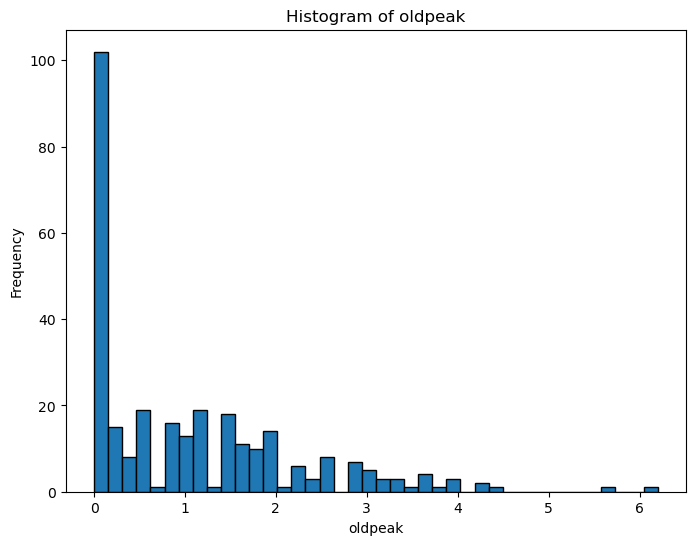

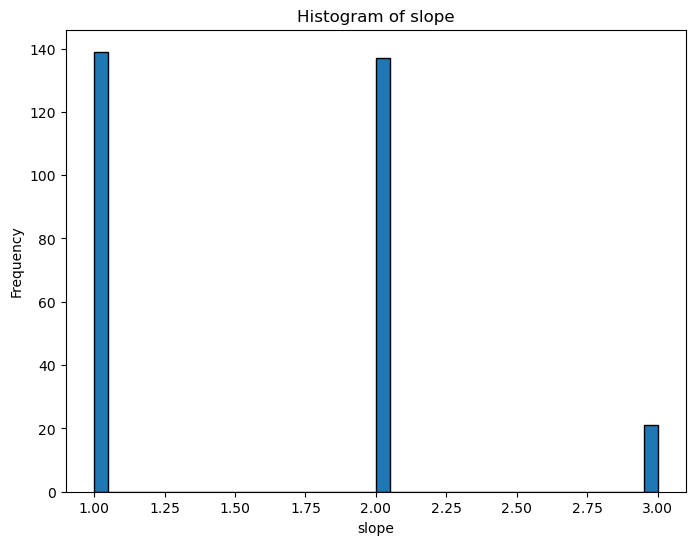

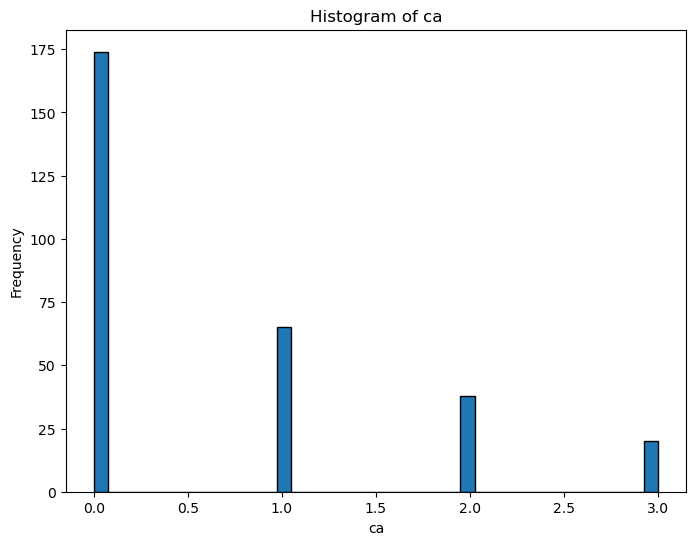

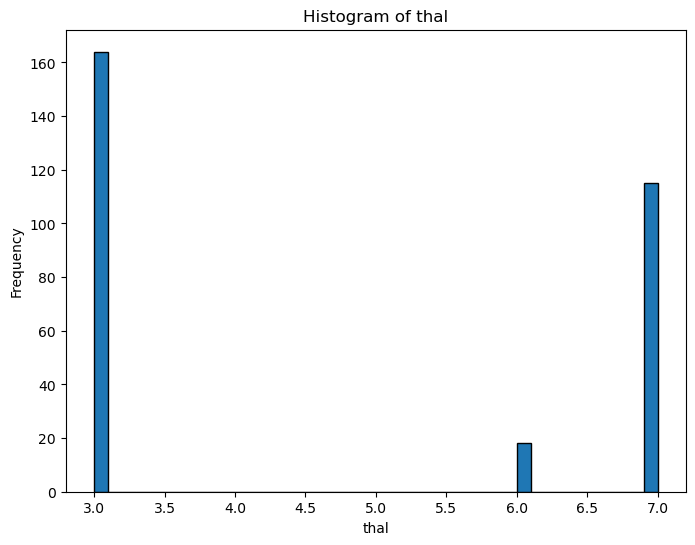

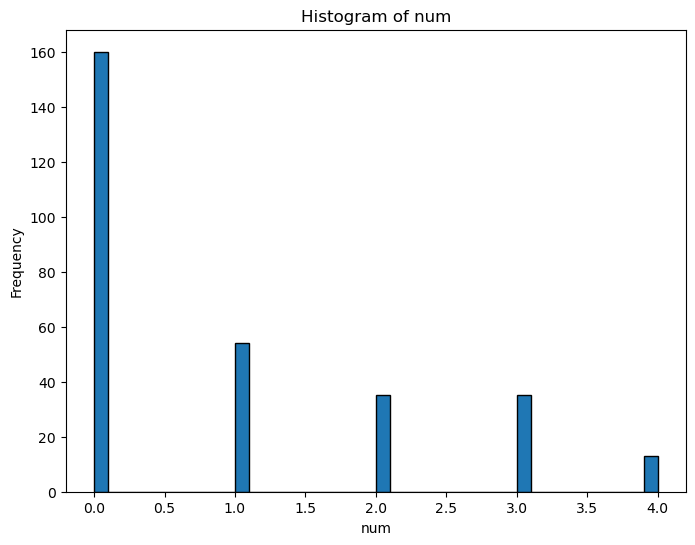

In [8]:
##Visualizing the data
##We see some features without Normality due to outliers as we suspected

for col in data.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data[col], bins=40, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [9]:
##Now for feature engineering

##Looking at the distribution of the graphs, I will eyeball the cut-offs of "chol" and "trestbps" 
##to get Normal distribution
data = data[data['chol'] <= 400]
data = data[data['trestbps'] <= 170]

##High cholestral is typically 240 and above, creating a feature for it might help indicate heart disease.
##Similar process for "trestbps" (resting heart rate), "thalach", and "oldpeak". Also, we binarize the target variable.
data['high_chol'] = (data['chol'] > 240).astype(int)
data['high_bp'] = (data['trestbps'] > 140).astype(int)
data['low_thalach'] = (data['thalach'] < 100).astype(int)
data['high_oldpeak'] = (data['oldpeak'] > 2.0).astype(int)
data['target'] = (data['num'] > 0).astype(int)

##We one-hot encode, now because this data is not ordinal, leaving it as label encoded is not optimal for the
##models I am going to use (RandomForest, XGBoost, SVM)
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']
for col in categorical_cols:
    data[col] = data[col].astype('category')

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

##Looks a lot better satistically
data.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,high_chol,...,cp_4,restecg_1,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0,ca_1.0,ca_2.0,ca_3.0
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,54.278169,0.693662,130.070423,243.742958,0.133803,149.457746,0.316901,1.022887,0.922535,0.492958,...,0.475352,0.010563,0.485915,0.457746,0.066901,0.063380,0.373239,0.221831,0.123239,0.066901
std,9.099572,0.461786,15.609025,45.918665,0.341041,23.154611,0.466090,1.134834,1.221561,0.500833,...,0.500274,0.102414,0.500684,0.499091,0.250292,0.244076,0.484519,0.416211,0.329292,0.250292
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,120.000000,211.000000,0.000000,132.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,152.500000,0.000000,0.800000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,140.000000,273.250000,0.000000,166.250000,1.000000,1.600000,2.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,77.000000,1.000000,170.000000,394.000000,1.000000,202.000000,1.000000,6.200000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
data.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,high_chol,...,cp_4,restecg_1,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0,ca_1.0,ca_2.0,ca_3.0
0,63,1,145,233,1,150,0,2.3,0,0,...,0,0,1,0,1,1,0,0,0,0
1,67,1,160,286,0,108,1,1.5,2,1,...,1,0,1,1,0,0,0,0,0,1
2,67,1,120,229,0,129,1,2.6,1,0,...,1,0,1,1,0,0,1,0,1,0
3,37,1,130,250,0,187,0,3.5,0,1,...,0,0,0,0,1,0,0,0,0,0
4,41,0,130,204,0,172,0,1.4,0,0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
##Define the target variable and features used, note that because RandomForest and XGBoost are not sensitive to
##scaling, we input the features as is. However, for SVM we will have to scale our data

##We will also be using GridSearchCV to optimize the hyperparameters

target = data['target']

features = data[['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'high_chol','high_bp','low_thalach', 'high_oldpeak',
                 'cp_2', 'cp_3', 'cp_4','restecg_1', 'restecg_2','slope_2', 
                 'slope_3','thal_6.0', 'thal_7.0','ca_1.0', 'ca_2.0', 'ca_3.0']]

# Train/test split on 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

param_grid = {'n_estimators': [100, 200],'max_depth': [None, 10, 20],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,scoring='f1',n_jobs=-1,verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [13]:
##Printing results

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.89      0.86      0.87        28

    accuracy                           0.88        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.88      0.88      0.88        57

Confusion Matrix:
[[26  3]
 [ 4 24]]


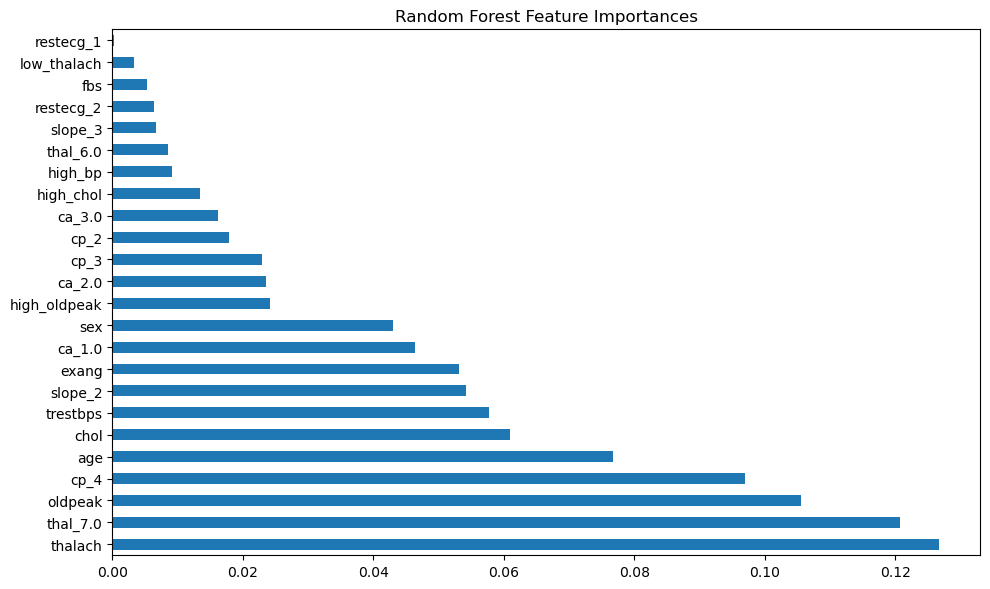

In [14]:
##Feature importances to see what can be removed in the future and highlight what helps in indicating heart disease
##using this dataset.

importances = pd.Series(best_rf.feature_importances_, index=features.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

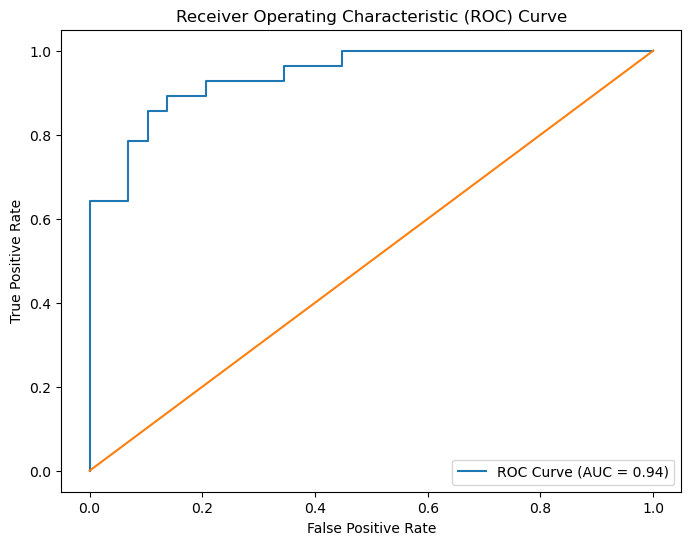

In [15]:
##ROC Curve graph

y_probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
##Let's try XGBoost next, GridSearch was not working for some reason so I used AI to help me manually input
##the hyperparameters

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, 
                                                    random_state=42)

xgb = XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],use_label_encoder=False,eval_metric='logloss',
    random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred = xgb.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.78      0.69      0.73        26

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57

Confusion Matrix:
[[26  5]
 [ 8 18]]


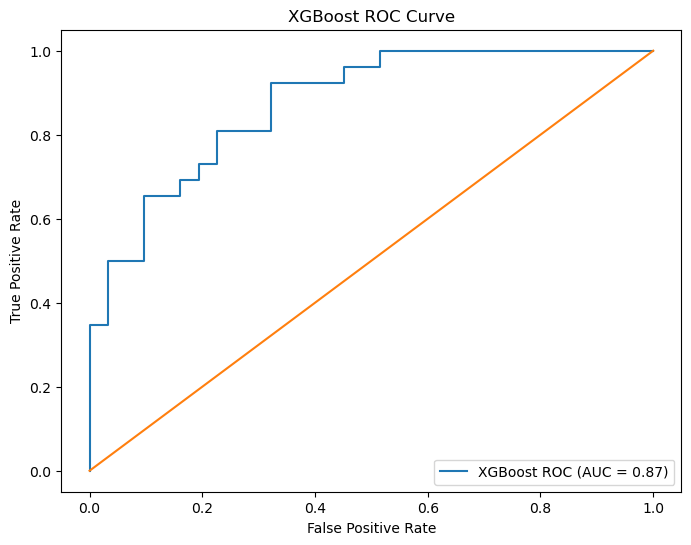

In [20]:
y_probs = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
##Now for SVM

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, 
                                                    random_state=42)

In [22]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=42))
])

svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [23]:
y_pred = svm_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        31
           1       0.83      0.73      0.78        26

    accuracy                           0.81        57
   macro avg       0.81      0.80      0.80        57
weighted avg       0.81      0.81      0.81        57

Confusion Matrix:
[[27  4]
 [ 7 19]]


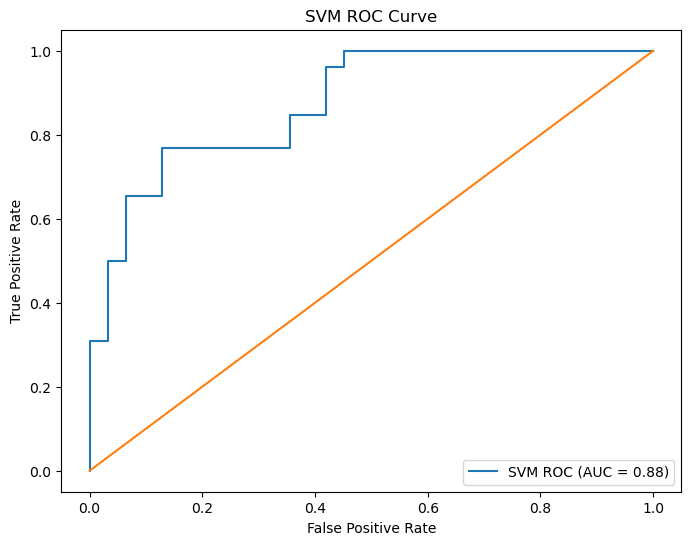

In [24]:
y_probs = svm_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"SVM ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc='lower right')
plt.show()